# Introduction

We'll do the following:
* fit a deep learning model with [Keras](https://keras.io/)
* identify and deal with overfitting
* use word embeddings
* build on a pretrained model

# Set-up of the project
We'll start by importing some packages.

In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Then we set some parameters that will be used throughout the notebook.

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

We read in the csv with the tweets data and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets.

We'll only keep the *text* column as input and the *Sentiment* column as the target. 

In [3]:
df = pd.read_csv('Final_training_data.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['content', 'Sentiment']]
df.head()

,content,Sentiment
27086,Right now Efia Odo is resourceful than Shatta ...,Positive
164182,#FixTheCountry,Neutral
167743,"People in Accra, for your information dumsor i...",Positive
104825,@ameyaw112 Kwaadaso Travis Scott we no get ein...,Neutral
55642,Primary four pupils to sit National Standard T...,Positive


# Data preparation

### Data cleaning
The first thing we'll do is removing stopwords. These words do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the mentions.

In [4]:
df = df[df['Sentiment'].notnull()]

In [5]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.content.apply(remove_stopwords).apply(remove_mentions)
df.head()

,content,Sentiment
27086,Right now Efia Odo is resourceful than Shatta ...,Positive
164182,#FixTheCountry,Neutral
167743,"People in Accra, for your information dumsor i...",Positive
104825,@ameyaw112 Kwaadaso Travis Scott we no get ein...,Neutral
55642,Primary four pupils to sit National Standard T...,Positive


### Train-Test split
The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the *train_test_split* method of scikit-learn.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.Sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 180988
# Test data samples: 20110


In [7]:
X_train.head()

175939    God given us everything prosper country. No bl...
185122    Food prices going up. Data costly though use b...
49138     The DJBLACK (toontoom) Daily out! https://t.co...
14265     #fixthecountry Clear example leaders.. Mother ...
106126                                       #FixTheCountry
Name: content, dtype: object

In [8]:
X_train.to_csv("X_train_data.csv", encoding='utf-8-sig', index=False)

In [9]:
y_train.head()

175939     Neutral
185122    Negative
49138      Neutral
14265     Positive
106126     Neutral
Name: Sentiment, dtype: object

In [10]:
y_train.to_csv("y_train_data.csv", encoding='utf-8-sig', index=False)

In [11]:
X_test.head()

99246     Instead #FixTheCountry Vice President Bawumia ...
126980    wished money taken trend unnecessary hashtag s...
106100    Nothing free Herh Ghana 🇬🇭 #FixTheCountryNow #...
148523    Honestly, it’s sad. We Minister Transport. We ...
84324            Is anyone registered certificate #FixTh...
Name: content, dtype: object

In [12]:
X_test.to_csv("X_test_data.csv", encoding='utf-8-sig', index=False)

In [13]:
y_test.head()

99246      Neutral
126980    Negative
106100    Positive
148523    Negative
84324      Neutral
Name: Sentiment, dtype: object

In [14]:
y_test.to_csv("y_test_data.csv", encoding='utf-8-sig', index=False)

### Converting words to numbers
To use the text as input for a model, we first need to convert the tweet's words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the train set.

We clean up the text by applying *filters* and putting the words to *lowercase*. Words are separated by spaces.

In [15]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 180988 documents
10000 words in dictionary
Top 5 most common words are: [('fixthecountry', 196810), ('t', 82090), ('co', 81937), ('https', 81408), ('ghana', 21681)]


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the *text_to_sequences* method of the Tokenizer.

In [16]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"#FixTheCountry https://t.co/wDLqiBIu64" is converted into [84, 464, 12, 166, 2844, 7, 11, 378, 1893, 1562, 1]


These integers should now be converted into a one-hot encoded features.

In [17]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[84, 464, 12, 166, 2844, 7, 11, 378, 1893, 1562, 1]" is converted into [0. 1. 0. ... 0. 0. 0.]
For this example we have 11.0 features with a value of 1.


### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [18]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"Neutral" is converted into 1
"1" is converted into [0. 1. 0.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [19]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (18099, 10000)


# Deep learning

### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [20]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


2021-12-10 17:09:53.842356: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 17:09:53.850753: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [21]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [22]:
base_history = deep_model(base_model)

To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [23]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

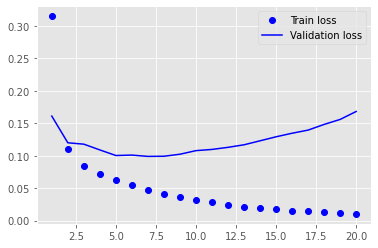

In [24]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

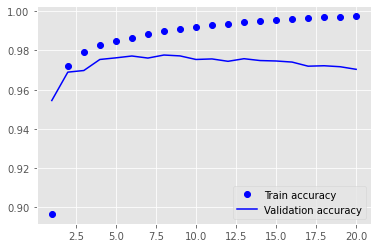

In [25]:
eval_metric(base_history, 'accuracy')

### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [26]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [27]:
reduced_history = deep_model(reduced_model)

In [28]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

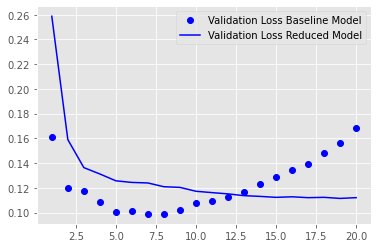

In [29]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [30]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [31]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

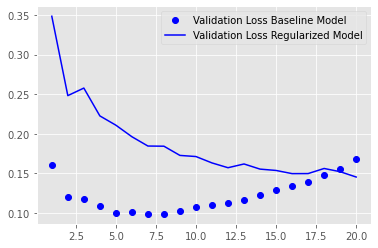

In [32]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [33]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [34]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

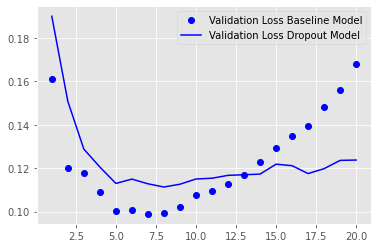

In [35]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [36]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [37]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

20110/20110 [==============================] - 8s 404us/step
/n
Test accuracy of baseline model: 97.07%


In [38]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

20110/20110 [==============================] - 5s 268us/step
/n
Test accuracy of reduced model: 97.80%


In [39]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

20110/20110 [==============================] - 7s 330us/step
/n
Test accuracy of regularized model: 97.24%


In [40]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

20110/20110 [==============================] - 7s 343us/step
/n
Test accuracy of dropout model: 97.44%


In [46]:
print('/n')
print("confusion matrix")
print('/n')
CR=confusion_matrix(y_train_rest, y_valid)
print(CR)
print('/n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

/n
confusion matrix
/n


ValueError: Found input variables with inconsistent numbers of samples: [162889, 18099]